# Classification using Convolutional Neural Networks
In this notebook we will look at convolutional neural networks for multiclass classification on [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The code is written using [PyTorch](https://pytorch.org/docs/stable/index.html) library. For faster training, it is advisable to run this notebook on [Google Colab](colab.research.google.com)
![cifar-10](https://drive.google.com/uc?id=1HiezR5ZhSo4WpFdG99pFn0If8j3M4A5O)


## Imports



In [21]:
import torch, torchvision
from torch import optim
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,ConfusionMatrixDisplay
from tqdm.notebook import tqdm

In [2]:
#Setting the device conditional on GPU availability
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

## Dataloader

In [3]:
#HyperParameters
val_size = 0.2
train_batch_size = 20
val_batch_size = 40
test_batch_size = 40
num_workers = 1

In [4]:
#Initializing the torchvision transforms (https://pytorch.org/vision/stable/transforms.html)
#For CIFAR-10, the mean over all images is [0.4914, 0.4822, 0.4465] and the std is [0.2023, 0.1994, 0.2010]
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
#Getting the train, valid and test datasets
train_dataset = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
val_dataset = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_valid)
test_dataset = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
#Getting the train and validation indices
num_train = len(train_dataset)
indices = np.array(range(num_train))
np.random.shuffle(indices)
split = int(val_size*num_train)
val_indices = indices[0:split]
train_indices = indices[split:]

#Samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

#Initializing the dataloaders
train_loader = DataLoader(train_dataset,batch_size=train_batch_size,num_workers=num_workers,sampler=train_sampler)
val_loader = DataLoader(val_dataset,batch_size=val_batch_size,num_workers=num_workers,sampler=val_sampler)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=test_batch_size,num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


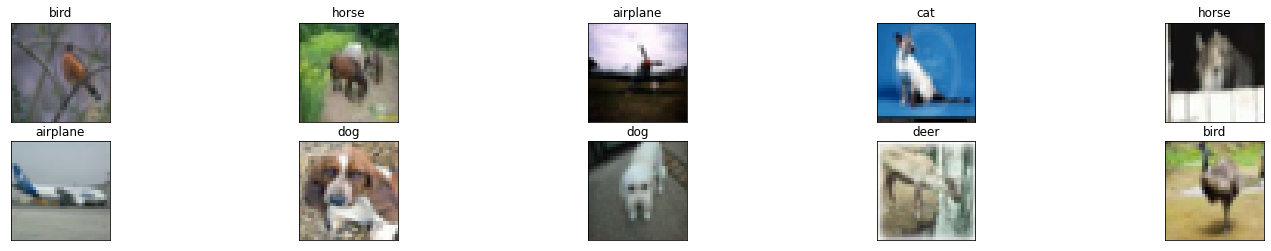

In [7]:
#Visualizing the dataloader (Choosing val_loader because train_loader has random cropping transform)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 4))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    #Un-normalizing the image
    image = np.transpose((images[idx]*np.array([0.2023, 0.1994, 0.2010]).reshape(3,1,1) + np.array([0.4914, 0.4822, 0.4465]).reshape(3,1,1)),(1,2,0))
    plt.imshow(image)
    ax.set_title(classes[labels[idx]])

## CNN Model

In [8]:
class ConvNet(nn.Module):
  def __init__(self):
      super(ConvNet, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
      self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
      self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
      self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))
      self.pool = nn.MaxPool2d(2,2)
      self.fc1 = nn.Linear(in_features=8*8*256, out_features=512)
      self.fc2 = nn.Linear(in_features=512, out_features=64)
      self.Dropout = nn.Dropout(0.25)
      self.fc3 = nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
      x = F.relu(self.conv1(x)) #32*32*48
      x = F.relu(self.conv2(x)) #32*32*96
      x = self.pool(x) #16*16*96
      x = self.Dropout(x)
      x = F.relu(self.conv3(x)) #16*16*192
      x = F.relu(self.conv4(x)) #16*16*256
      x = self.pool(x) # 8*8*256
      x = self.Dropout(x)
      x = x.view(-1, 8*8*256) # reshape x
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.Dropout(x)
      x = self.fc3(x)
      return x

In [9]:
model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (Dropout): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## Training

In [10]:
#Hyperparameters
lr = 0.01 #Learning Rate
n_epochs = 30 #Number of epochs

In [11]:
#Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [14]:
#Train Loop
best_accuracy = -1
for i in range(n_epochs):
  print("Epoch",i+1)
  #Training

  train_loss = 0
  train_preds = []
  train_gt = []

  model.train()

  for image,label in train_loader:
    image,label = image.to(device),label.to(device)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output,label)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_gt.extend(list(label.cpu().numpy()))
    train_preds.extend(list(np.argmax(output.cpu().detach().numpy(),axis=1)))

  #Validation

  val_preds = []
  val_gt = []

  model.eval()

  for image,label in val_loader:
    image,label = image.to(device),label.to(device)
    output = model(image)
    val_gt.extend(list(label.cpu().numpy()))
    val_preds.extend(list(np.argmax(output.cpu().detach().numpy(),axis=1)))

  train_loss_avg = train_loss/len(train_loader.dataset)
  train_accuracy = accuracy_score(train_gt,train_preds)
  val_accuracy = accuracy_score(val_gt,val_preds)

  print("Training Loss %f , Train Accuracy %f , Validation Accuracy %f" %(train_loss_avg,train_accuracy,val_accuracy))
  if val_accuracy >  best_accuracy:
    if i: print("Validation accuracy increased from %f to %f" %(best_accuracy, val_accuracy))
    best_accuracy = val_accuracy
    print("Saving model checkpoint")
    torch.save(model.state_dict(), 'model_cifar.pt')

Epoch 1
Training Loss 0.021679 , Train Accuracy 0.815000 , Validation Accuracy 0.818500
Saving model checkpoint
Epoch 2
Training Loss 0.021050 , Train Accuracy 0.818075 , Validation Accuracy 0.822700
Validation accuracy increased from 0.818500 to 0.822700
Saving model checkpoint
Epoch 3
Training Loss 0.020340 , Train Accuracy 0.825100 , Validation Accuracy 0.826400
Validation accuracy increased from 0.822700 to 0.826400
Saving model checkpoint
Epoch 4
Training Loss 0.019444 , Train Accuracy 0.832750 , Validation Accuracy 0.826800
Validation accuracy increased from 0.826400 to 0.826800
Saving model checkpoint
Epoch 5
Training Loss 0.019128 , Train Accuracy 0.837800 , Validation Accuracy 0.832500
Validation accuracy increased from 0.826800 to 0.832500
Saving model checkpoint
Epoch 6
Training Loss 0.018380 , Train Accuracy 0.841325 , Validation Accuracy 0.835900
Validation accuracy increased from 0.832500 to 0.835900
Saving model checkpoint
Epoch 7
Training Loss 0.017643 , Train Accuracy 

## Evaluation

Testing
Accuracy: 0.8674
F1 Score: 0.8671466379109919


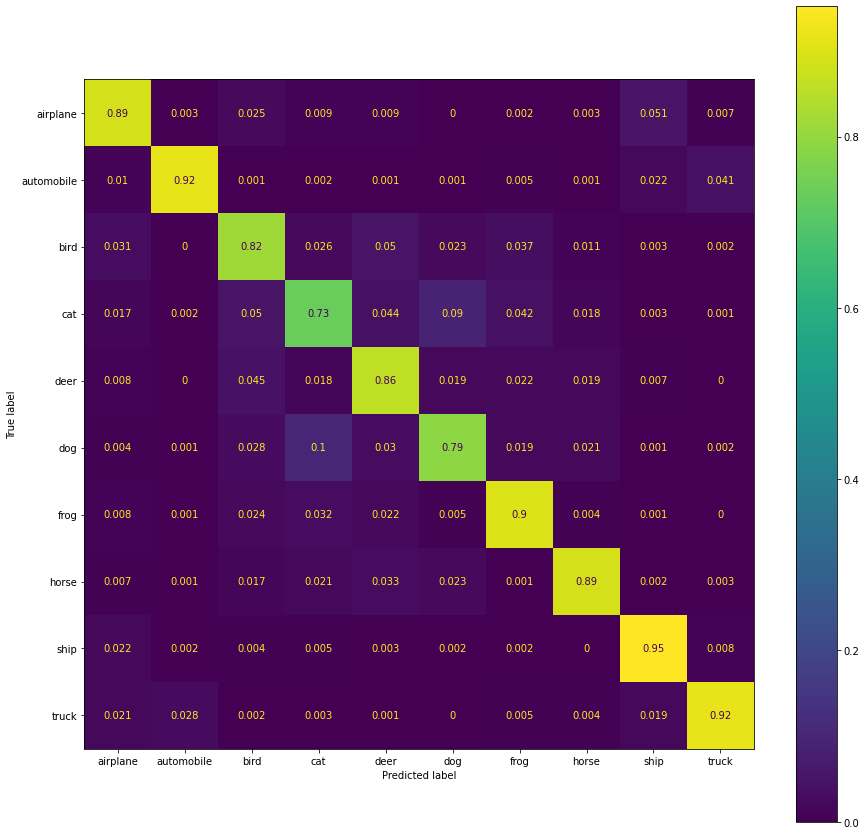

In [25]:
#Evaluate on test data using the model which has the best accuracy on validation data
model.load_state_dict(torch.load('model_cifar.pt'))
model.eval()
test_preds = []
test_gt = []
print("Testing")
for image,label in test_loader:
  image,label = image.to(device),label.to(device)
  output = model(image)
  test_gt.extend(list(label.cpu().numpy()))
  test_preds.extend(list(np.argmax(output.cpu().detach().numpy(),axis=1)))

print("Accuracy:",accuracy_score(test_gt,test_preds))
print("F1 Score:",f1_score(test_gt,test_preds,average='macro'))
fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(test_gt,test_preds,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot(ax=ax)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

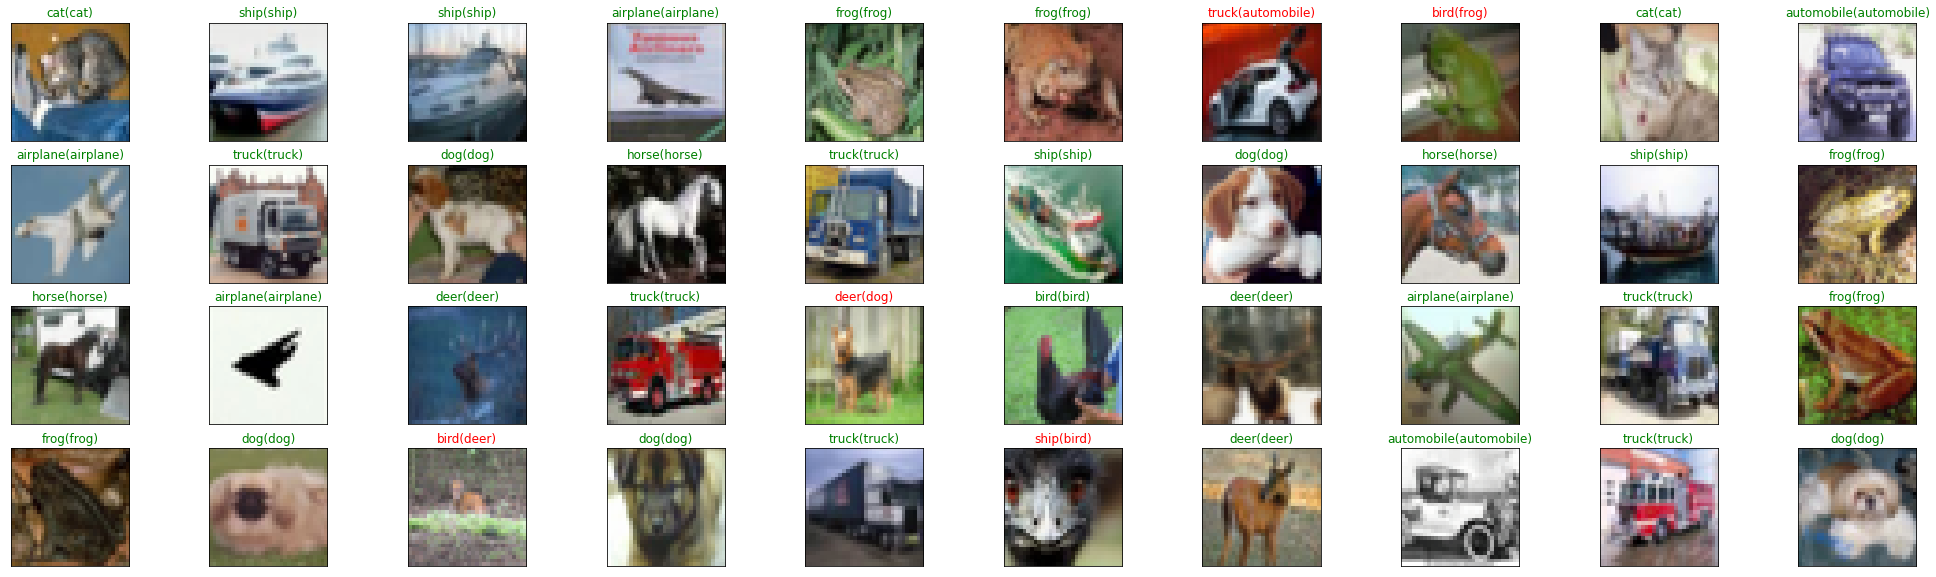

In [31]:
#Visualize Sample Test Results
dataiter = iter(test_loader)
images, labels = dataiter.next()
pred_labels = list(np.argmax(model(images.to(device)).cpu().detach().numpy(),axis=1))
true_labels = list(labels)
images = images.numpy()
fig = plt.figure(figsize=(35, 10))
for i in range(40):
    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    #Un-normalizing the image
    image = np.transpose((images[i]*np.array([0.2023, 0.1994, 0.2010]).reshape(3,1,1) + np.array([0.4914, 0.4822, 0.4465]).reshape(3,1,1)),(1,2,0))
    plt.imshow(image)
    ax.set_title(classes[pred_labels[i]]+"("+classes[true_labels[i]]+")",color='green' if pred_labels[i]== true_labels[i] else 'red')